In [1]:
import numpy as np
from math import fabs, sqrt, ceil, atan2, pi
def hough_ellipse_manual(img,threshold=4,min_size=4,maxsize=None, accuracy=1):
    # edge img , votes threshold for acc , min legnth for major axis , max length for minor axis
        if img.ndim != 2:
            raise ValueError('The input image must be 2D.')
        bin_size = accuracy * accuracy
        maxsize=np.round(0.5 * img.shape[0]) # take max legnth as half the legnth of 1st dim 
        max_b_squared = maxsize * maxsize
        pixels = np.row_stack(np.nonzero(img)) # get edge pixels// possible ellipse points
        num_pixels = pixels.shape[1]
        results=[]
        acc=[]
        for p1 in range(num_pixels):
            p1x = pixels[1, p1]
            p1y = pixels[0, p1]

            for p2 in range(p1):
                p2x = pixels[1, p2]
                p2y = pixels[0, p2]

                # Candidate: center (xc, yc) and main axis a
                dx = p1x - p2x
                dy = p1y - p2y
                a = 0.5 * sqrt(dx * dx + dy * dy)
                if a > 0.5 * min_size:
                    xc = 0.5 * (p1x + p2x)
                    yc = 0.5 * (p1y + p2y)

                    for p3 in range(num_pixels):
                        p3x = pixels[1, p3]
                        p3y = pixels[0, p3]
                        dx = p3x - xc
                        dy = p3y - yc
                        d = sqrt(dx * dx + dy * dy)
                        if d > min_size:
                            dx = p3x - p1x
                            dy = p3y - p1y
                            cos_tau_squared = ((a*a + d*d - dx*dx - dy*dy)
                                               / (2 * a * d))
                            cos_tau_squared *= cos_tau_squared
                            # Consider b2 > 0 and avoid division by zero
                            k = a*a - d*d * cos_tau_squared
                            if k > 0 and cos_tau_squared < 1:
                                b_squared = a*a * d*d * (1 - cos_tau_squared) / k
                                # b2 range is limited to avoid histogram memory
                                # overflow
                                if b_squared <= max_b_squared:
                                    acc.append(b_squared)
                    if len(acc) > 0:
                        bins = np.arange(0, np.max(acc)+ bin_size, bin_size)
                        hist, bin_edges = np.histogram(acc, bins=bins)
                        hist_max = np.max(hist)
                        if hist_max > threshold:
                            orientation = atan2(p1x - p2x, p1y - p2y)
                            b = sqrt(bin_edges[hist.argmax()])
                            # to keep ellipse_perimeter() convention
                            if orientation != 0:
                                orientation = pi - orientation
                                # When orientation is not in [-pi:pi]
                                # it would mean in ellipse_perimeter()
                                # that a < b. But we keep a > b.
                                if orientation > pi:
                                    orientation = orientation - pi / 2.
                                    a, b = b, a
                            results.append(( hist_max,
                                            yc, xc,
                                            a, b,
                                            orientation))
                        acc = []                

        return np.array(results, dtype=[ ('accumulator', np.intp),
                                    ('yc', np.float64),
                                    ('xc', np.float64),
                                    ('a', np.float64),
                                    ('b', np.float64),
                                    ('orientation', np.float64)])

In [2]:
from skimage.transform import hough_ellipse
from skimage.feature import canny
from skimage import data,color

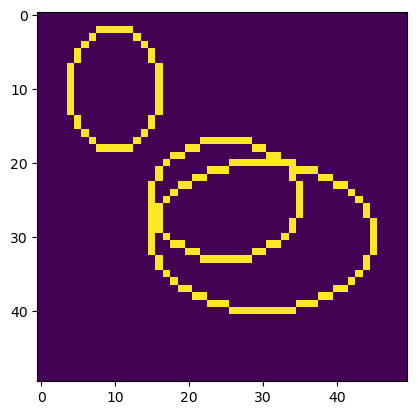

In [14]:
from skimage.draw import ellipse_perimeter
import matplotlib.pyplot as plt
img = np.zeros((50, 50,3), dtype=np.uint8)

rr, cc = ellipse_perimeter(10, 10, 6, 8)
rr2, cc2 = ellipse_perimeter(30, 30, 15, 10,0)
rr3, cc3 = ellipse_perimeter(25, 25, 10, 8,0)
img[cc, rr] = (0,0,255)
img[cc2, rr2] = (0,0,255)
img[cc3, rr3] = (0,0,255)
image_gray = color.rgb2gray(img)
plt.imshow(image_gray)
hough_ell=hough_ellipse_manual(image_gray, threshold=10,accuracy=3,min_size=4,maxsize=100)

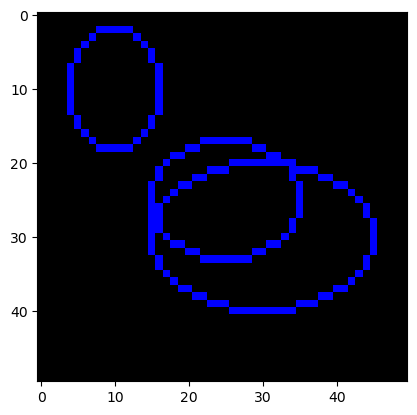

In [15]:
hough_ell.sort(order='accumulator')
plt.imshow(img)

In [26]:
import cv2
def draw_result_ellipse(originalimg,sortedresult,numb_el):
    newimg=np.copy(originalimg)
    for i in range(numb_el):
        
        best = list(sortedresult[i-1])
        if best is None:
            break
        
        yc, xc, a, b = (int(round(x)) for x in best[1:5])
        orientation = best[5]
        if( a != 0 and b !=0):
            newimg=cv2.ellipse(newimg, (xc,yc), (a,b),
         orientation  , 0, 360, (0,255,0), 1)

        else:
            numb_el+=1 # get next ellipse
    return newimg
    
       

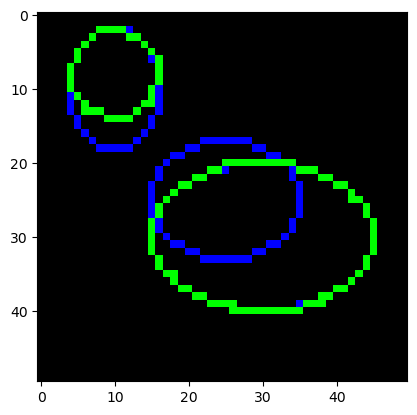

In [17]:
newimage=draw_result_ellipse(img,hough_ell,3)
plt.imshow(newimage)

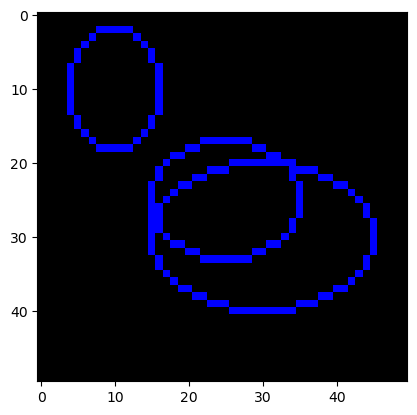

In [18]:
plt.imshow(img)

In [19]:
print(hough_ell)

[(11,  8.5, 10. ,  6.        , 6.02079729, 3.05845142)
 (11,  8.5, 10. ,  6.02079729, 6.        , 1.65393756)
 (11, 10. ,  9. ,  8.        , 4.24264069, 0.        ) ...
 (33, 18.5, 24. , 21.36000936, 0.        , 1.929567  )
 (33, 19. , 23.5, 20.40220576, 0.        , 1.86929526)
 (38, 30. , 30. , 15.        , 9.94987437, 1.57079633)]


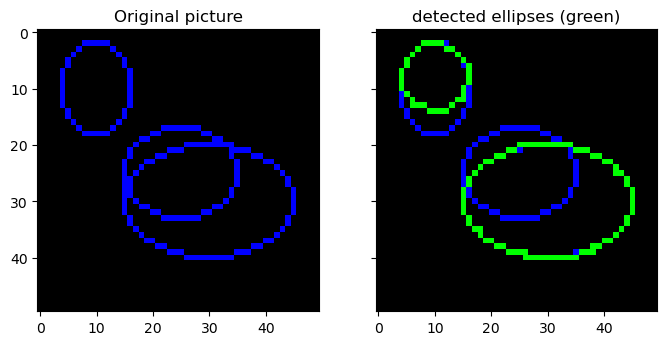

In [21]:
fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(img)

ax2.set_title('detected ellipses (green)')
ax2.imshow(newimage)


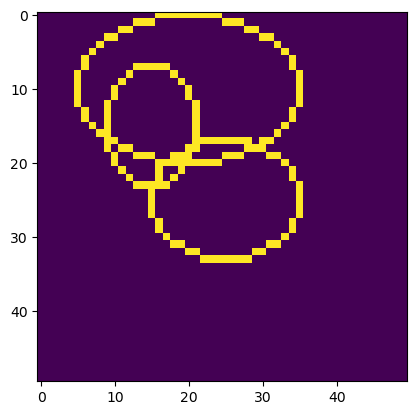

In [31]:
img2 = np.zeros((50, 50,3), dtype=np.uint8)

rr, cc = ellipse_perimeter(15, 15, 6, 8)
rr2, cc2 = ellipse_perimeter(20, 10, 15, 10,0)
rr3, cc3 = ellipse_perimeter(25, 25, 10, 8,0)
img2[cc, rr] = (0,0,255)
img2[cc2, rr2] = (0,0,255)
img2[cc3, rr3] = (0,0,255)
image_gray2 = color.rgb2gray(img2)
plt.imshow(image_gray2)
hough_ell=hough_ellipse_manual(image_gray2, threshold=7,accuracy=3,min_size=4,maxsize=100)

[( 8,  1.5, 19. ,  0.        ,  8.01560977, 3.07917384)
 ( 8,  1.5, 21. ,  8.01560977,  0.        , 1.63321514)
 ( 8,  2. , 17. ,  0.        ,  8.06225775, 3.01723766) ...
 (27, 14.5, 18. ,  0.        , 14.63728117, 1.7078625 )
 (27, 15. , 16.5, 15.00833102,  0.        , 3.10827166)
 (38, 10. , 20. , 15.        ,  9.94987437, 1.57079633)]


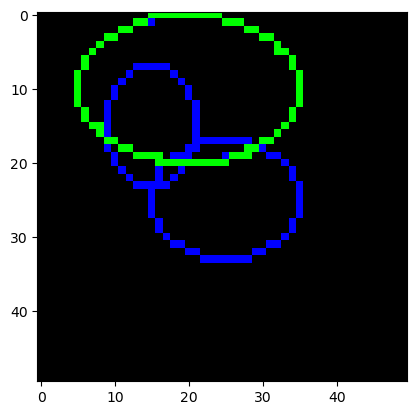

In [37]:
hough_ell.sort(order='accumulator')
newimage2=draw_result_ellipse(img2,hough_ell,3)
plt.imshow(newimage2)
print(hough_ell)

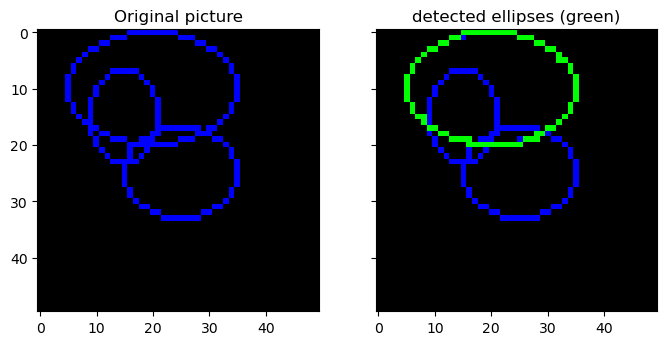

In [38]:
fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(img2)

ax2.set_title('detected ellipses (green)')
ax2.imshow(newimage2)